## Predicting the Minority Percentage for Public High Schools
**This notebook explores predicting the Minority Percentage for public high schools in North Carolina.** 
* Using **NO** racial composition data, can we predict the minority percentage for a public high school?
* The North Carolina Educational Attainment Data Repository for Machine Learning is located on Github at: https://github.com/jakemdrew/EducationDataNC 
* Since the response variable is highly unbalanced we choose to set the *class_weight* parameter to 'balanced.  While this lowers overall accuracy, it almost doubles recall which is the model's ability to accurately identify highly segeregated schools. 

**For documentation on various Generalized Linear Models in Sklearn see:**
* http://scikit-learn.org/stable/modules/linear_model.html
* https://stackoverflow.com/questions/33845539/modelling-probabilities-in-a-regularized-logistic-regression-model-in-python

In [1]:
#import required Libraries
import pandas as pd
import numpy as np

#The 'path' variable may also be a URL pointing to the proper raw file path on github: 
#path="https://raw.githubusercontent.com/jakemdrew/EducationDataNC/master/2017/Machine%20Learning%20Datasets/PublicHighSchools2017_ML.csv"

path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2015/Machine Learning Datasets/PublicMiddleSchools2015_ML.csv"
schData=pd.read_csv(path, low_memory=False)

#inspect data 
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Columns: 419 entries, student_num to unit_code
dtypes: float64(318), int64(101)
memory usage: 1.7 MB


In [2]:
#The MinorityPct field was removed from the _ML dataset for being highly correlated with other racial composition fields
#We will merge it back in to the _ML dataset, since this is our response variable. 
path="C:/Users/Jake/Documents/GitHub/EducationDataNC/2015/School Datasets/PublicMiddleSchools2015.csv"
responseData=pd.read_csv(path, low_memory=False)

responseData = responseData[['unit_code','MinorityPct']]

#inspect data 
responseData.info(verbose=False)



#Merge the response variable into our _ML data (schData)
schData = schData.merge(responseData,how='left',on='unit_code', suffixes=('', '_Drop'))

print('*********************************After: MinorityPct Added***********************')
schData.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Columns: 2 entries, unit_code to MinorityPct
dtypes: float64(1), int64(1)
memory usage: 8.5 KB
*********************************After: MinorityPct Added***********************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 0 to 536
Columns: 420 entries, student_num to MinorityPct
dtypes: float64(319), int64(101)
memory usage: 1.7 MB


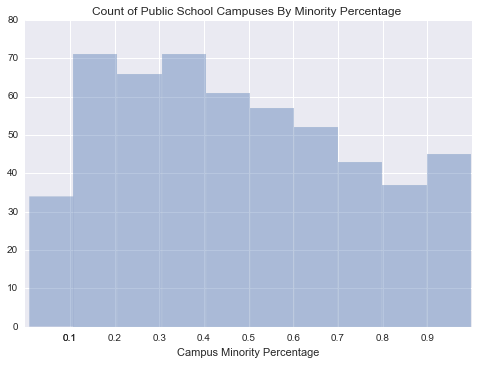

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
hst = sns.distplot(schData['MinorityPct'], kde=False)
hst.set_xlabel("Campus Minority Percentage")
#Assign output of plt.xticks() to x to surpress xticks() function output 
_ = plt.xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10])
_ = plt.title('Count of Public School Campuses By Minority Percentage ')

In [4]:
#Delete all racial composition data from our dataset. 
raceCompositionFields = ['Indian Male','Asian Male','Hispanic Male','Black Male','White Male'
                         ,'Pacific Island Male','Pacific Island Female','Two or  More Male','Two or  More Female'
                         ,'Pacific Island','Majority_Minority','White_Pct','Two or More']

RaceCols = schData.columns[(schData.columns.str.lower().str.contains('indian')) | 
                           (schData.columns.str.lower().str.contains('asian')) |
                           (schData.columns.str.lower().str.contains('hispanic')) |
                           (schData.columns.str.lower().str.contains('black')) |
                           (schData.columns.str.lower().str.contains('white')) |
                           (schData.columns.str.lower().str.contains('pacific island')) |
                           (schData.columns.str.lower().str.contains('two or  more')) |
                           (schData.columns.str.lower().str.contains('minority'))]
RaceCols

Index([u'EOCMathI_CACR_AmericanIndian', u'EOG/EOCSubjects_CACR_AmericanIndian',
       u'EOGGr6_CACR_AmericanIndian', u'EOGGr7_CACR_AmericanIndian',
       u'EOGGr8_CACR_AmericanIndian', u'EOGMathGr3-8_CACR_AmericanIndian',
       u'EOGMathGr6_CACR_AmericanIndian', u'EOGMathGr7_CACR_AmericanIndian',
       u'EOGMathGr8_CACR_AmericanIndian', u'EOGMathGr8_GLP_AmericanIndian',
       u'EOGReadingGr3-8_CACR_AmericanIndian',
       u'EOGReadingGr6_CACR_AmericanIndian',
       u'EOGReadingGr7_CACR_AmericanIndian',
       u'EOGReadingGr8_CACR_AmericanIndian',
       u'EOGScienceGr5&8_CACR_AmericanIndian', u'EOCMathI_CACR_Asian',
       u'EOG/EOCSubjects_CACR_Asian', u'EOGGr6_CACR_Asian',
       u'EOGGr7_CACR_Asian', u'EOGGr8_CACR_Asian', u'EOGMathGr3-8_CACR_Asian',
       u'EOGMathGr6_CACR_Asian', u'EOGMathGr7_CACR_Asian',
       u'EOGMathGr8_CACR_Asian', u'EOCMathI_CACR_Black',
       u'EOG/EOCSubjects_CACR_Black', u'EOGGr6_CACR_Black',
       u'EOGGr7_CACR_Black', u'EOGGr8_CACR_Black', u'EO

In [5]:
# create x explanatory and y response variables for regression
Y_MinorityPct = schData['MinorityPct'] 
Y = Y_MinorityPct

#Delete all racial composition data from our dataset.
X_highSchools = schData.drop(RaceCols, axis=1)

#inspect data 
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537 entries, 0 to 536
Columns: 331 entries, student_num to unit_code
dtypes: float64(230), int64(101)
memory usage: 1.4 MB


In [6]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
#from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
#scaler = StandardScaler()
#scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
#X_highSchools = scaler.transform(X_highSchools)

## Cross Validation
**Cross validation is performed using repeated holdout using ShuffleSplit()**
* Ten folds are used
* The split is: 90% training data and 10% test data
* A random seed is set so the same random test and training splits are used each time cross validation is performed.

In [7]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.10, random_state=0)

## Classifier Evaluation
** The following function performs cross validation using cross_validate() for classification estimators and returns accuracy, precision, and recall.** 

In [8]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print classReport
    print confMat
    print acc

## Minority Percent - Logistic Regression 
**This model uses a Logistic Regression to classify public high schools as greater than 40% to 90% minorities. Please see documentation here: **
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [9]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.80

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:   20.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [10]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [11]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.40

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.83148
The average precision for all cv folds is: 			 0.85111
The average recall for all cv folds is: 			 0.83669
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.851852,0.892857,0.833333
1,0.814815,0.833333,0.833333
2,0.870370,0.843750,0.931034
3,0.796296,0.870968,0.794118
4,0.888889,0.909091,0.909091
5,0.833333,0.833333,0.862069
6,0.759259,0.812500,0.787879
7,0.870370,0.888889,0.857143
8,0.870370,0.857143,0.818182
9,0.759259,0.769231,0.740741


In [12]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.50

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.8537
The average precision for all cv folds is: 			 0.83537
The average recall for all cv folds is: 			 0.85398
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.777778,0.791667,0.730769
1,0.870370,0.904762,0.791667
2,0.870370,0.806452,0.961538
3,0.833333,0.851852,0.821429
4,0.907407,0.866667,0.962963
5,0.851852,0.880000,0.814815
6,0.703704,0.703704,0.703704
7,0.944444,0.956522,0.916667
8,0.907407,0.842105,0.888889
9,0.870370,0.750000,0.947368


In [13]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.83      0.82      0.82       299
       True       0.77      0.79      0.78       238

avg / total       0.80      0.80      0.80       537

[[244  55]
 [ 50 188]]
0.8044692737430168


In [14]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.60

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.86667
The average precision for all cv folds is: 			 0.77395
The average recall for all cv folds is: 			 0.88971
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.888889,0.850000,0.850000
1,0.851852,0.800000,0.800000
2,0.888889,0.769231,1.000000
3,0.777778,0.642857,0.900000
4,0.907407,0.840000,0.954545
5,0.851852,0.782609,0.857143
6,0.740741,0.608696,0.736842
7,0.925926,0.850000,0.944444
8,0.944444,0.846154,0.916667
9,0.888889,0.750000,0.937500


In [15]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.88      0.83      0.86       359
       True       0.70      0.78      0.74       178

avg / total       0.82      0.82      0.82       537

[[299  60]
 [ 39 139]]
0.8156424581005587


**The next model uses a Logistic Regression to classify public high schools as greater than 90% minority**

In [16]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.70

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.84259
The average precision for all cv folds is: 			 0.64433
The average recall for all cv folds is: 			 0.82554
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.833333,0.705882,0.750000
1,0.851852,0.666667,0.769231
2,0.851852,0.666667,0.933333
3,0.777778,0.578947,0.733333
4,0.851852,0.695652,0.941176
5,0.870370,0.722222,0.866667
6,0.777778,0.526316,0.769231
7,0.907407,0.714286,0.909091
8,0.925926,0.666667,1.000000
9,0.777778,0.500000,0.583333


In [17]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.94      0.85      0.89       411
       True       0.62      0.82      0.71       126

avg / total       0.86      0.84      0.85       537

[[349  62]
 [ 23 103]]
0.8417132216014898


In [18]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.80

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.89444
The average precision for all cv folds is: 			 0.62513
The average recall for all cv folds is: 			 0.89284
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.888889,0.692308,0.818182
1,0.907407,0.583333,1.000000
2,0.870370,0.642857,0.818182
3,0.870370,0.500000,1.000000
4,0.907407,0.722222,1.000000
5,0.888889,0.666667,0.800000
6,0.907407,0.700000,0.777778
7,0.944444,0.727273,1.000000
8,0.925926,0.600000,1.000000
9,0.833333,0.416667,0.714286


In [19]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.96      0.89      0.92       455
       True       0.56      0.78      0.65        82

avg / total       0.90      0.87      0.88       537

[[405  50]
 [ 18  64]]
0.8733705772811918


In [20]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.90

#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)

The average accuracy for all cv folds is: 			 0.91667
The average precision for all cv folds is: 			 0.51802
The average recall for all cv folds is: 			 0.76167
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.925926,0.666667,0.666667
1,0.925926,0.500000,1.000000
2,0.870370,0.454545,0.833333
3,0.888889,0.166667,0.500000
4,0.907407,0.692308,0.900000
5,0.870370,0.333333,0.750000
6,0.962963,0.800000,0.800000
7,0.907407,0.400000,0.500000
8,0.962963,0.666667,1.000000
9,0.944444,0.500000,0.666667


In [21]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)

             precision    recall  f1-score   support

      False       0.98      0.95      0.96       492
       True       0.58      0.82      0.68        45

avg / total       0.95      0.93      0.94       537

[[465  27]
 [  8  37]]
0.9348230912476723


# Top Performing Model Analisys
## Testing Scaled vs. Unscaled Training Data
**Cross validation is performed using both scaled and unscaled training data.**
* A grid search is also performed on the scaled training data to determine the best parameters to use with the scaled training data.
* We scale the data prior to looking at feature importances.  Since the raw features have different dynamic ranges, scaling the data first allows us to compare the model's coefficients accurately. 
* The scaled data makes more accurate predictions in many cases but not always!

In [22]:
#Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analisys 
X_highSchools_Scl = scaler.transform(X_highSchools)

**In this case, I tested scaling the data before cross validation as well.**

In [23]:
#Convert Y to a binary response variable 
Y = Y_MinorityPct >= 0.9

#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced'] #,'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=8)]: Done 140 out of 140 | elapsed:    9.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['lbfgs'], 'max_iter': [100, 500], 'penalty': ['l2'], 'random_state': [0], 'class_weight': ['balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [24]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [25]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)

The average accuracy for all cv folds is: 			 0.86667
The average precision for all cv folds is: 			 0.36273
The average recall for all cv folds is: 			 0.73
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.833333,0.363636,0.666667
1,0.851852,0.300000,0.750000
2,0.796296,0.307692,0.666667
3,0.870370,0.142857,0.500000
4,0.851852,0.571429,0.800000
5,0.870370,0.333333,0.750000
6,0.944444,0.625000,1.000000
7,0.851852,0.250000,0.500000
8,0.888889,0.400000,1.000000
9,0.907407,0.333333,0.666667


In [26]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

      False       0.98      0.90      0.94       492
       True       0.43      0.82      0.56        45

avg / total       0.94      0.89      0.91       537

[[442  50]
 [  8  37]]
0.8919925512104283


In [27]:
Y.value_counts()

False    492
True      45
Name: MinorityPct, dtype: int64

## Feature Importance for the Top Performing Model
**Here we look at the features driving the top performing model's decisions.**
* The top performing model predicts the minority percentage of public high schools with 95% accuracy.
* All training data is scaled to remove differences in coefficient scales since many features have different dynamic ranges.
* A final model is created using all the scaled training data.  
* All model coefficients are sorted by absolute value in descending order.
* Sorted coefficient values are plotted showing the top 75 features with the strongest positive and negative correlations. 

In [28]:
#Create a classification estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

#Fit the model using all of the scaled training data
classifierEst.fit(X_highSchools_Scl, Y)

from sklearn.metrics import confusion_matrix

In [29]:
#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = classifierEst.coef_.ravel()
feature_names = X_highSchools.columns.values
linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False )

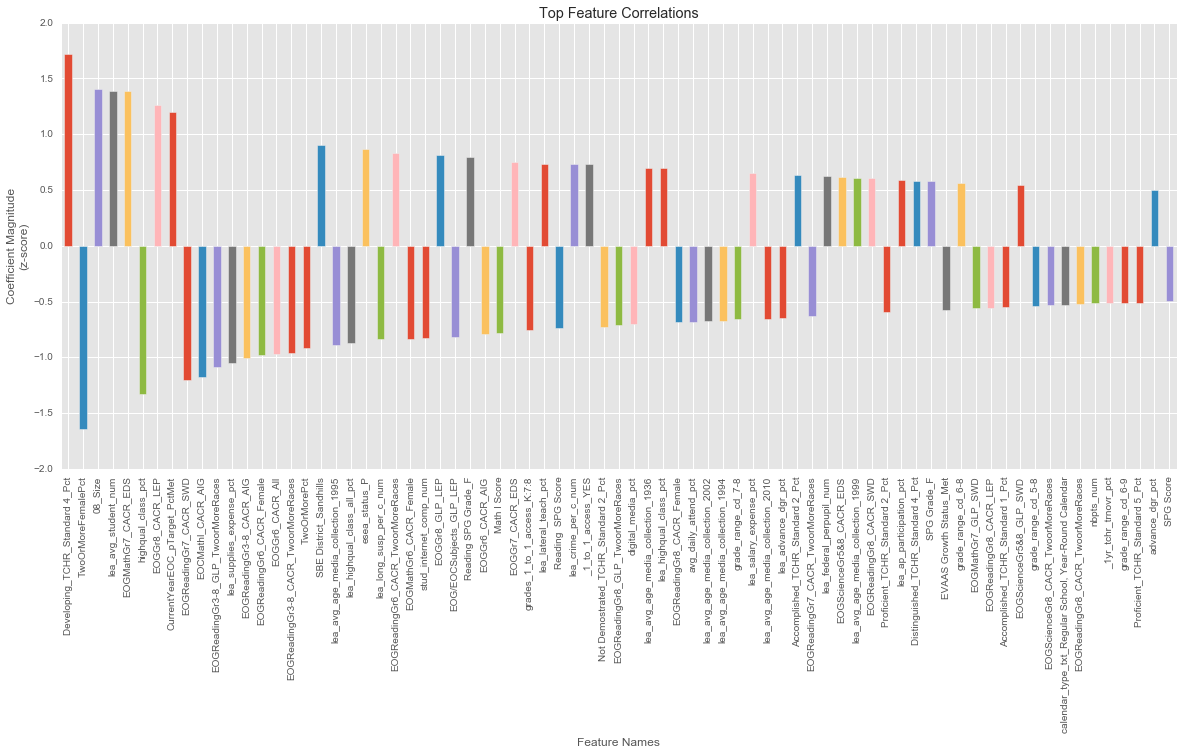

In [30]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75)

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='bar', figsize=(20,8))

ax.set_title("Top Feature Correlations")
ax.set_ylabel("Coefficient Magnitude\n(z-score)")
ax.set_xlabel("Feature Names")
plt.show()

## Feature Importance Using Recursive Feature Elimination
**Please see the following documentation for this section**
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
* http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
* http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV
* https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models

In [31]:
#Convert Y to the top performing binary response 
Y = Y_MinorityPct >= 0.9

In [32]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.1, train_size=None),
   estimator=LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 81


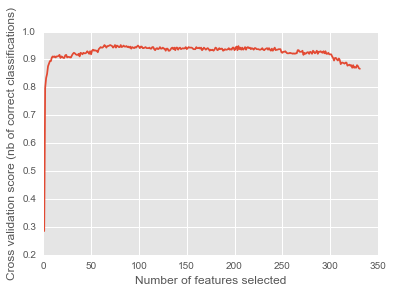

In [33]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [34]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
80,EOGMathGr6_GLP_LEP,0.951852
63,EOGReadingGr7_CACR_EDS,0.951852
69,EOG/EOCSubjects_CACR_LEP,0.951852
74,EOGGr7_GLP_LEP,0.951852
83,EOGMathGr8_CACR_LEP,0.950000
68,EOCMathI_CACR_LEP,0.950000
70,EOG/EOCSubjects_GLP_LEP,0.950000
98,EOGGr6_CACR_SWD,0.950000
76,EOGGr8_GLP_LEP,0.950000
86,EOGReadingGr3-8_GLP_LEP,0.948148
